In [ ]:
import seaborn as sns

import pandas as pd

import numpy as np
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split

import os

from sklearn.linear_model import SGDClassifier

In [ ]:
### Load labeled data

city_names = ['bern', 'davi','doug','elpa','fres','henn','sanf']
city_dict = dict.fromkeys(city_names)
for filename in os.listdir("../prop_labeled/"):
    key = filename[0:4]
    city_dict[key] = pd.read_csv(os.path.join("../prop_labeled/",filename))

    
bos_labeled = pd.read_csv("/Users/rossmarino/Desktop/DS5500-fall2020-rb-bc-ek-rm/census-csv/prop_change_suffolk_labeled.csv")
bos_labeled['label'] = [bos_labeled['Gent_Label'][i].lower() for i in range(len(bos_labeled['Gent_Label'])) ]


city_dict['bost'] = bos_labeled

In [ ]:
## Remove NaN from Labels
for key, data in city_dict.items():
    city_dict[key] = data[data.label.notnull()]


In [ ]:
## Subset to predictors found in LDA lasso regularization

for key, df in city_dict.items():
    city_dict[key] ={'x' : df[["prop.change.housing.renter.occupied.householder.race.White",
                        "prop.change.housing.owner.occupied.householder.race.Black",
                        "prop.change.housing.owner.occupied.householder.race.Other"]],
                    'y' : df['label']} 
    


In [ ]:
## Remove nan and inf values
for key, df in city_dict.items():    
    with pd.option_context('mode.use_inf_as_na', True):
        city_dict[key]['x'] = df['x'].fillna(0)


In [ ]:
## Split each city into Train, Test sets
train_data = {}
test_data = {}
for key, data in city_dict.items():
    train_x, test_x, train_y, test_y = train_test_split(city_dict[key]['x'],
                                                        city_dict[key]['y'], 
                                                        test_size = 0.2,
                                                        random_state = 42)
    train_data[key]= {'x':train_x,'y':train_y}
    test_data[key]={'x':test_x,'y':test_y}


In [ ]:
test_cities_ohe = {}
for city, data in test_data.items():
    test_cities_ohe[city] = pd.DataFrame({'eligible': data['y'] == 'eligible',
                                          'ineligible': data['y']=='ineligible',
                                          'gentrified': data['y'] == 'gentrified'})

In [ ]:
## Merge all training data
train_all = {'x': pd.DataFrame(columns = train_data['bost']['x'].columns),
             'y': np.array([])}
test_all = {'x': pd.DataFrame(columns = test_data['bost']['x'].columns),
             'y': np.array([])}
for key, data in train_data.items():
    
    train_all['x'] = train_all['x'].append(train_data[key]['x'], ignore_index=True)
    train_all['y'] = np.append(train_all['y'], np.array(train_data[key]['y']))
    
    test_all['x'] = test_all['x'].append(test_data[key]['x'], ignore_index=True)
    test_all['y'] = np.append(test_all['y'], np.array(test_data[key]['y']))

In [ ]:
train_ohe = pd.DataFrame({'eligible': train_all['y'] == 'eligible',
              'ineligible': train_all['y']=='ineligible',
              'gentrified': train_all['y'] == 'gentrified'})

In [ ]:
test_ohe = pd.DataFrame({'eligible': test_all['y'] == 'eligible',
                        'ineligible': test_all['y'] == 'ineligible',
                        'gentrified': test_all['y'] == 'gentrified'})

### Modeling on All Cities

In [ ]:
"""
train_x is pd.df or np.arr with independent variables
train_y is pd.df of one-hot-encoding of labels with label names as only columns
params, scoring, refit are all GridSearchCV parameters

return dict of best model for a label with label_name as key
"""

def run_gcv(train_x,train_y, params ={"C" : range(20,25),'gamma': range(10, 15)}, 
               scoring ='f1', refit = 'f1' ):
    
    models_bylabel = {}
    for col_name, col_labels in train_y.iteritems():
        svm = SVC()
        grid_clf = GridSearchCV(svm, params,scoring=scoring, refit=refit )
        grid_clf.fit(train_x, col_labels)
        models_bylabel[col_name] = grid_clf.best_estimator_
    
    return models_bylabel

In [69]:
"""
model: svm of one-label binary classification
label: the label the model classifies
test_x: dict with cities as keys and value as dicts of 'x','y': test features/labels (test_data)
test_y_ohe: dict with cities as keys and value as pd.DataFrame as one-hot-encoded labels (test_cities_ohe)
mets: the metrics to use

return scores: dict with cities as keys and performance as values
"""
def get_score_cities(model, label, test_x, test_y_ohe, mets=['f1','accuracy', 'recall']):
    scores = dict.fromkeys(test_x.keys())
    for key in scores.keys():
        scores[key] = dict.fromkeys(mets)
    
    for city, data in test_x.items():
        preds = model.predict(data['x'])
        if 'f1' in mets:
            scores[city]['f1'] = metrics.f1_score(test_y_ohe[city][label], preds)
        if 'accuracy' in mets:
            scores[city]['accuracy'] = metrics.accuracy_score(test_y_ohe[city][label], preds)
        if 'recall' in mets:
            scores[city]['recall'] = metrics.recall_score(test_y_ohe[city][label], preds)
    return scores

In [ ]:
##### Grid Search CV to find best meta parameters
params = {"C" : [0.1,0.5,0.01,1],
         'gamma': [0.0005,0.001,0.006,]}
svm = SVC()
grid_svm = GridSearchCV(svm, params, scoring=['f1', 'accuracy', 'recall'], refit='f1')
#best_svm = grid_svm.fit(city_dict['bost']['x'], city_dict['bost']['y'])
best_svm = grid_svm.fit(train_all['x'], train_ohe['gentrified'])

feats = ['params','mean_test_f1','rank_test_f1', 'mean_test_accuracy','rank_test_recall','mean_test_recall', 'rank_test_accuracy']
pd.DataFrame(grid_svm.cv_results_)[feats].sort_values(by='rank_test_f1')

grid_svm.best_params_

In [ ]:
## elig : c=22, gamma =12
## inelig : c= 6, gamma = 0.6
## gent : doesn't predict any gentrification no matter the parameters
        ### recall always 0

In [ ]:
all_models = {'eligible': SVC(C=22,gamma=12).fit(train_all['x'], train_ohe['eligible']),
             'ineligible': SVC(C=6, gamma=0.6).fit(train_all['x'], train_ohe['ineligible'])}

In [87]:
el_all_preds = all_models['eligible'].predict(test_all['x'])
inel_all_preds = all_models['ineligible'].predict(test_all['x'])
el_acc = metrics.accuracy_score(test_ohe['eligible'], el_all_preds)
el_f1 = metrics.f1_score(test_ohe['eligible'], el_all_preds)
inel_acc = metrics.accuracy_score(test_ohe['ineligible'], inel_all_preds)
inel_f1 = metrics.f1_score(test_ohe['ineligible'], inel_all_preds)

In [70]:
elig_scores = get_score_cities(all_models['eligible'], 'eligible', test_data, test_cities_ohe)

In [71]:
inelig_scores = get_score_cities(all_models['ineligible'], 'ineligible',test_data,test_cities_ohe)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

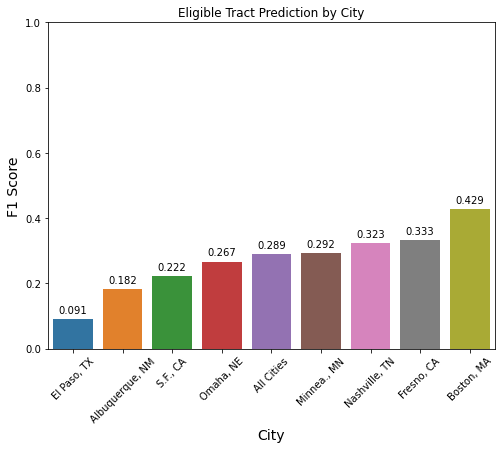

In [96]:
city_full_names = ['Albuquerque, NM','Boston, MA', 'Nashville, TN', 'Omaha, NE','El Paso, TX','Fresno, CA', 'Minnea., MN', 'S.F., CA']
data_scores = pd.DataFrame({'names':city_full_names, 'f1':[elig_scores[city]['f1'] for city in city_names]})
data_scores = data_scores.append({'names': 'All Cities', 'f1':el_f1}, ignore_index=True)
plt.figure(figsize=(8, 6))
splot=sns.barplot(data=data_scores.sort_values(by='f1'), x='names', y='f1')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylim(0,1)
plt.title('Eligible Tract Prediction by City')
plt.xlabel("City", size=14)
plt.ylabel("F1 Score", size=14)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

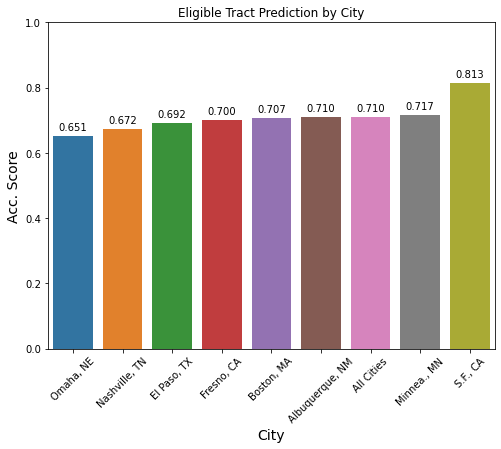

In [97]:

data_scores = pd.DataFrame({'names':city_full_names, 'accuracy':[elig_scores[city]['accuracy'] for city in city_names]})
data_scores = data_scores.append({'names': 'All Cities', 'accuracy':el_acc}, ignore_index=True)

plt.figure(figsize=(8, 6))
splot=sns.barplot(data=data_scores.sort_values(by='accuracy'), x='names', y='accuracy')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylim(0,1)
plt.title('Eligible Tract Prediction by City')
plt.xlabel("City", size=14)
plt.ylabel("Acc. Score", size=14)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

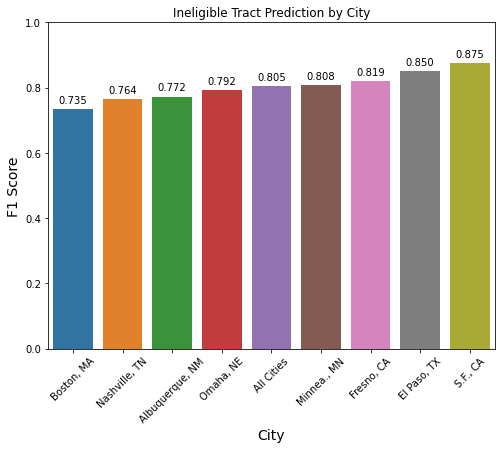

In [98]:
data_scores = pd.DataFrame({'names':city_full_names, 'f1':[inelig_scores[city]['f1'] for city in city_names]})
data_scores = data_scores.append({'names': 'All Cities', 'f1':inel_f1}, ignore_index=True)

plt.figure(figsize=(8, 6))
splot=sns.barplot(data=data_scores.sort_values(by='f1'), x='names', y='f1')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylim(0,1)
plt.title('Ineligible Tract Prediction by City')
plt.xlabel("City", size=14)
plt.ylabel("F1 Score", size=14)
plt.xticks(rotation=45)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8]),
 <a list of 9 Text major ticklabel objects>)

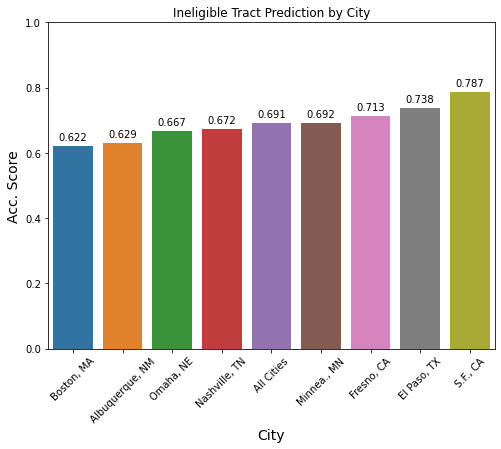

In [99]:
data_scores = pd.DataFrame({'names':city_full_names, 'accuracy':[inelig_scores[city]['accuracy'] for city in city_names]})
data_scores = data_scores.append({'names': 'All Cities', 'accuracy':inel_acc}, ignore_index=True)

plt.figure(figsize=(8, 6))
splot=sns.barplot(data=data_scores.sort_values(by='accuracy'), x='names', y='accuracy')
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.3f'), 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', 
                   xytext = (0, 9), 
                   textcoords = 'offset points')
plt.ylim(0,1)
plt.title('Ineligible Tract Prediction by City')
plt.xlabel("City", size=14)
plt.ylabel("Acc. Score", size=14)
plt.xticks(rotation=45)